In [2]:
# Cell 1: Download and preprocess CIFAR-10 and PCam datasets for ResNet34 (224x224)

import torch, gc
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from torchvision.utils import draw_bounding_boxes
# from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GradCAMPlusPlus as GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from captum.attr import  GradientShap   
import torch.nn.functional as F
import torch.nn as nn

import os, random
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr, kendalltau
# from skimage.metrics import structural_similarity as ssim
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms.functional as TF

import pickle
import pandas as pd
from collections import Counter
from PIL import Image
import quantus
from quantus.metrics.complexity import Sparseness
from quantus.metrics.faithfulness import PixelFlipping
# from quantus.metrics.robustness import Consistency
from pathlib import Path

from functools import partial
import copy



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#For reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
# torch.set_num_threads(4)  # 4 threads per worker
# torch.multiprocessing.set_sharing_strategy('file_system')


Using device: cuda


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


Load the dataset with transformations

In [ ]:
# ImageNet normalization stats for ResNet34 pretrained weights [6][9]

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]



# PCam transform: resize to 224x224, convert to tensor, normalize
pcam_train_transform = transforms.Compose([
    # Apply augmentations on the original 96x96 images FIRST
    transforms.RandomResizedCrop(
        size=96,  # Operate on the native PCam resolution (96x96)
        scale=(0.8, 1.0),  # Randomly crop 80-100% of the original area
        interpolation=transforms.InterpolationMode.BICUBIC  # Smoother scaling
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    # Resize to 224x224 AFTER augmentations (minimizes upscaling artifacts)
    transforms.Resize(
        (224, 224), 
        interpolation=transforms.InterpolationMode.BICUBIC  # Higher quality
    ),
    # Conservative color augmentations (medical images are sensitive to color shifts)
    transforms.ColorJitter(
        brightness=0.1,  # Keep subtle for H&E-stained tissue
        contrast=0.1,
        saturation=0.0,   # Avoid altering saturation (critical for PCam)
        hue=0.0
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# PCam transform: resize to 224x224, convert to tensor, normalize
pcam_test_transform = transforms.Compose([
    # Resize to 224x224 (minimizes upscaling artifacts)
    transforms.Resize(
        (224, 224), 
        interpolation=transforms.InterpolationMode.BICUBIC  # Higher quality
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


# PCam download and preprocessing [1][2][7]
pcam_train = datasets.PCAM(
    root='./data',
    split='train',
    download=False,
    transform=pcam_train_transform
)
pcam_val = datasets.PCAM(
    root='./data',
    split='val',
    download=False,
    transform=pcam_test_transform
)
pcam_test = datasets.PCAM(
    root='./data',
    split='test',
    download=False,
    transform=pcam_test_transform
)

# pcam_train_loader = DataLoader(pcam_train, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True,persistent_workers=True)
# pcam_val_loader = DataLoader(pcam_val, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True,persistent_workers=True)
# pcam_test_loader = DataLoader(pcam_test, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, persistent_workers=True)

# print("CIFAR-10 and PCam datasets are downloaded and preprocessed to 224x224 for ResNet34.")


Make the balanced dataset indices

In [ ]:
def stratified_subset(dataset, n_samples, seed=42):
    # Extract labels from the dataset
    labels = np.array([dataset[i][1] for i in range(len(dataset))])
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n_samples, random_state=seed)
    idx, _ = next(sss.split(np.zeros(len(labels)), labels))
    return Subset(dataset, idx), idx

def stratified_train_val_split(dataset, train_size, val_size, seed=42):
    labels = np.array(dataset.targets)
    all_indices = np.arange(len(labels))
    
    train_idx, val_idx = train_test_split(
        all_indices,
        train_size=train_size,
        test_size=val_size,
        stratify=labels,
        random_state=seed
    )
    
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    return train_subset, val_subset, train_idx, val_idx

# # Usage example:
# cifar_train_balanced, cifar_val_balanced, cifar_train_idx, cifar_val_idx = stratified_train_val_split(cifar10_train, 40000, 10000)
# cifar_tracking, cifar_tracking_idx = stratified_subset(cifar_val_subset, 100)

# # # Example for PCam (assuming you have pcam_train, pcam_val, pcam_test)
# pcam_train_balanced, train_idx = stratified_subset(pcam_train, 40000)
# pcam_val_balanced, val_idx = stratified_subset(pcam_val, 10000)
# pcam_test_balanced, test_idx = stratified_subset(pcam_test, 10000)
# pcam_tracking, pcam_tracking_idx = stratified_subset(pcam_val_subset, 100)



NameError: name 'cifar_val_subset' is not defined

In [ ]:
# For PCam train
pcam_train_labels = [pcam_train_balanced[i][1] for i in range(len(pcam_train_balanced))]
train_counts = Counter(pcam_train_labels)
print("PCam Train class counts:", train_counts)

# For PCam val
pcam_val_labels = [pcam_val_balanced[i][1] for i in range(len(pcam_val_balanced))]
val_counts = Counter(pcam_val_labels)
print("PCam Val class counts:", val_counts)

# For PCam test
pcam_test_labels = [pcam_test_balanced[i][1] for i in range(len(pcam_test_balanced))]
test_counts = Counter(pcam_test_labels)
print("PCam Test class counts:", test_counts)

# For CIFAR-10 train
cifar_train_labels = [cifar_train_balanced[i][1] for i in range(len(cifar_train_balanced))]
train_counts_cifar = Counter(cifar_train_labels)
print("CIFAR-10 Train class counts:", train_counts_cifar)

# For CIFAR-10 val
cifar_val_labels = [cifar_val_balanced[i][1] for i in range(len(cifar_val_balanced))]
val_counts_cifar = Counter(cifar_val_labels)
print("CIFAR-10 Val class counts:", val_counts_cifar)


PCam Train class counts: Counter({1: 20000, 0: 20000})
PCam Val class counts: Counter({0: 5005, 1: 4995})
PCam Test class counts: Counter({0: 5002, 1: 4998})
CIFAR-10 Train class counts: Counter({6: 4000, 7: 4000, 8: 4000, 3: 4000, 2: 4000, 1: 4000, 4: 4000, 9: 4000, 0: 4000, 5: 4000})
CIFAR-10 Val class counts: Counter({2: 1000, 7: 1000, 1: 1000, 9: 1000, 6: 1000, 8: 1000, 0: 1000, 3: 1000, 5: 1000, 4: 1000})


In [ ]:
# For PCam tracking
pcam_tracking_labels = [pcam_tracking[i][1] for i in range(len(pcam_tracking))]
tracking_counts = Counter(pcam_tracking_labels)
print("PCam Tracking class counts:", tracking_counts)

# For CIFAR-10 tracking
cifar_tracking_labels = [cifar_tracking[i][1] for i in range(len(cifar_tracking))]
tracking_counts_cifar = Counter(cifar_tracking_labels)
print("CIFAR-10 Tracking class counts:", tracking_counts_cifar)

PCam Tracking class counts: Counter({0: 50, 1: 50})
CIFAR-10 Tracking class counts: Counter({8: 10, 4: 10, 0: 10, 6: 10, 5: 10, 3: 10, 2: 10, 1: 10, 9: 10, 7: 10})


In [7]:

# Save the balanced splits
# Create directories if they don't exist
os.makedirs('./data/balanced_splits', exist_ok=True)
# with open('./data/balanced_splits/pcam_train_idx.pkl', 'wb') as f:
#     pickle.dump(train_idx, f)
# with open('./data/balanced_splits/pcam_val_idx.pkl', 'wb') as f:
#     pickle.dump(val_idx, f)
# with open('./data/balanced_splits/pcam_test_idx.pkl', 'wb') as f:
#     pickle.dump(test_idx, f)
with open('./data/balanced_splits/pcam_tracking_idx.pkl', 'wb') as f:
    pickle.dump(pcam_tracking_idx, f)
# with open('./data/balanced_splits/cifar_train_idx.pkl', 'wb') as f:
#     pickle.dump(cifar_train_idx, f)
# with open('./data/balanced_splits/cifar_val_idx.pkl', 'wb') as f:
#     pickle.dump(cifar_val_idx, f)
with open('./data/balanced_splits/cifar_tracking_idx.pkl', 'wb') as f:
    pickle.dump(cifar_tracking_idx, f)
# For CIFAR-10 test set (use all indices, as you don't subset)
# cifar_test_idx = np.arange(len(cifar10_test))

# with open('./data/balanced_splits/cifar_test_idx.pkl', 'wb') as f:
#     pickle.dump(cifar_test_idx, f)


Make the subsets from saved indices

In [ ]:
batch_size = 500
workers = 4
print(f"Number of workers: {workers}")
# Load the balanced splits
# PCam
with open('./data/balanced_splits/pcam_train_idx.pkl', 'rb') as f:
    train_idx = pickle.load(f)
with open('./data/balanced_splits/pcam_val_idx.pkl', 'rb') as f:
    val_idx = pickle.load(f)
with open('./data/balanced_splits/pcam_test_idx.pkl', 'rb') as f:
    test_idx = pickle.load(f)
with open('./data/balanced_splits/pcam_tracking_idx.pkl', 'rb') as f:
    pcam_tracking_idx = pickle.load(f)

def create_random_subset(dataset, subset_length, seed=42):
    """
    Quickly creates a random subset of the dataset.
    """
    np.random.seed(seed)
    indices = np.random.choice(len(dataset), subset_length, replace=False)
    return Subset(dataset, indices)


pcam_train_subset = Subset(pcam_train, train_idx)
pcam_val_subset = Subset(pcam_val, val_idx)
pcam_test_subset = Subset(pcam_test, test_idx)
pcam_tracking_subset = Subset(pcam_val_subset, pcam_tracking_idx)


# Create DataLoaders
pcam_train_loader = DataLoader(
    pcam_train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    pin_memory=False,
    persistent_workers=False
)

pcam_test_loader = DataLoader(
    pcam_test_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

pcam_val_loader = DataLoader(
    pcam_val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

print(f"Pcam Train subset size: {len(pcam_train_subset)}")
print(f"Pcam Test subset size: {len(pcam_test_subset)}")
print(f"Pcam Validation subset size: {len(pcam_val_subset)}")
print(f"Pcam Tracking subset size: {len(pcam_tracking_subset)}")



Number of workers: 4
Pcam Train subset size: 40000
Pcam Test subset size: 10000
Pcam Validation subset size: 10000
Pcam Tracking subset size: 100


## Variance in dataset

In [ ]:
# For demonstration, collect first N samples
N = 2000
data_list, label_list = [], []
count = 0

for images, labels in pcam_train_loader:
    batch_size = images.size(0)
    images = images.view(batch_size, -1).cpu().numpy()  # flatten per image
    data_list.append(images)
    label_list.append(labels.cpu().numpy())
    count += batch_size
    if count >= N:  # break after collecting ~N images
        break

X = np.concatenate(data_list)[:N]
y = np.concatenate(label_list)[:N]


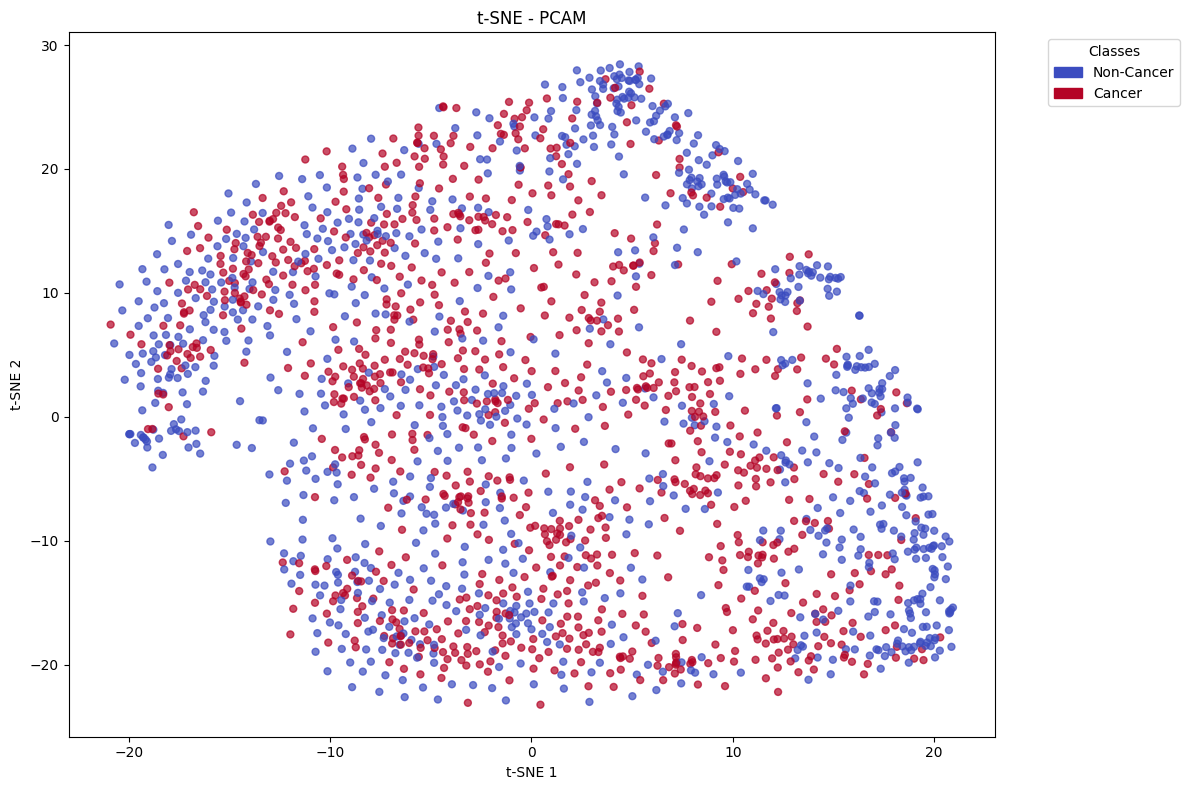

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the class names for PCAM
class_names = ['Non-Cancer', 'Cancer']

plt.figure(figsize=(12,8))
scatter = plt.scatter(
    X_embedded[:,0], X_embedded[:,1],
    c=y, cmap='coolwarm', s=25, alpha=0.7
)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE - PCAM')

# Manually create legend patches to match the colormap
cmap = plt.colormaps['coolwarm']
handles = [
    mpatches.Patch(color=cmap(0.0), label='Non-Cancer'),
    mpatches.Patch(color=cmap(1.0), label='Cancer')
]
plt.legend(handles=handles, title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [10]:
import numpy as np

# X: shape (num_samples, num_features)
# Example: X = np.concatenate(data_list) from your earlier code

# Variance across all samples for each feature (pixel or feature)
feature_variances = np.var(X, axis=0)

# Mean variance per feature (a simple global measure of variability)
mean_variability = np.mean(feature_variances)
print("Mean Variance (global variability):", mean_variability)

# Standard deviation
feature_stddevs = np.std(X, axis=0)
mean_stddev = np.mean(feature_stddevs)
print("Mean Standard Deviation (global variability):", mean_stddev)


Mean Variance (global variability): 1.2171263
Mean Standard Deviation (global variability): 1.0855138


In [11]:
sample_variances = np.var(X, axis=1)
print("Sample variances:", sample_variances)


Sample variances: [0.9425906  1.1431551  0.31399307 ... 1.2247479  1.5760325  1.1320624 ]


In [12]:
for label in np.unique(y):
    class_samples = X[y == label]
    class_variance = np.var(class_samples)
    print(f"Variance for class {label}: {class_variance}")


Variance for class 0: 1.7141194343566895
Variance for class 1: 1.305185317993164


Initializing CNN for both the datasets

In [ ]:
# Initialize ResNet34 model for CIFAR-10 and PCam
def initialize_resnet34(num_classes, device=None):
    """
    Initializes a ResNet34 model with a specified number of output classes.

    Args:
        num_classes (int): Number of output classes for the classification task.
        device (torch.device, optional): The device to load the model onto. Defaults to CUDA if available.

    Returns:
        torch.nn.Module: The initialized ResNet34 model.
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    print(f"Initialized ResNet34 for {num_classes} classes on {device} (DataParallel={torch.cuda.device_count() > 1})")
    return model.to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize models for PCam
pcam_model = initialize_resnet34(num_classes=2, device=device)


Initialized ResNet34 for 2 classes on cuda:0 (DataParallel=False)


<h1>This is for XAI AL but for specific cases</h1>

In [7]:
import json
import time
import os

def save_training_metadata(
    cycle,
    dataset_name,
    model_architecture,
    num_classes,
    train_loader,
    hyperparameters,
    val_metrics,
    class_weights=None,
    save_dir='/home/jovyan/data/models/pcam/random_sampling'
):
    """
    Save training metadata as a JSON file alongside model checkpoints.

    Args:
        cycle (int): Active learning cycle number.
        dataset_name (str): Name of the dataset.
        model_architecture (str): Model architecture name.
        num_classes (int): Number of output classes.
        train_loader (DataLoader): Training data loader to get dataset size.
        hyperparameters (dict): Dictionary of training hyperparameters.
        val_metrics (dict): Dictionary of validation metrics (e.g., loss, recall).
        class_weights (torch.Tensor, optional): Class weights used in training.
        save_dir (str): Directory to save the metadata JSON file.

    Returns:
        None
    """
    metadata = {
        "cycle": cycle,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "dataset": dataset_name,
        "model_architecture": model_architecture,
        "num_classes": num_classes,
        "train_size": train_loader,
        "hyperparameters": hyperparameters,
        "class_weights": class_weights.tolist() if class_weights is not None else None,
        "val_metrics": val_metrics
    }

    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Save metadata as JSON
    metadata_path = os.path.join(save_dir, f"{cycle}_metadata.json")
    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=2)

    print(f"Metadata saved to {metadata_path}")


CNN Training Code

In [ ]:

# ================== TORCH WRAPPER WITH EARLY STOPPING ==================
class TorchWrapper:
    def __init__(self, model):
        self.model = model
        self.device = next(model.parameters()).device
        self.best_weights = None
        
    def fit(self, train_loader, val_loader=None, epochs=5, patience=3, dataset_name='cifar10', cycle= 1, batch_size=32,  Labeled = 1,distributions =None):
        self.model.train()


        # # === NEW: Compute class weights for PCAM ===
        # if cycle >5:
        all_labels = []
        for _, labels in train_loader:
            all_labels.extend(labels.cpu().numpy())
        # classes = np.unique(all_labels)
        # class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=all_labels)
        # class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
        # if cycle > 9:
        #     class_weights = torch.tensor([0.4, 0.6], dtype=torch.float32).to(device)
        #     criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        # else:
        #     class_weights = torch.tensor([0.3, 0.7], dtype=torch.float32).to(device)
        #     criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


        # else:
        lr = 5e-5
        weight_decay = 1e-3
        schedular_patience = 6
        scheduler_factor = 0.1
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_factor)
        class_weights = None  
            # Track class distribution (new functionality)
        pos_count = np.sum(np.array(all_labels) == 1)
        neg_count = len(all_labels) - pos_count
        pos_pct = pos_count / len(all_labels) * 100
        neg_pct = neg_count / len(all_labels) * 100
        
        # Append to tracking list
        distributions.append({
            'cycle': cycle,
            'labeled_samples': len(all_labels),
            'pos_count': pos_count,
            'neg_count': neg_count,
            'pos_pct': pos_pct,
            'neg_pct': neg_pct,
            # 'pos_weight': class_weights[1].item(),
            # 'neg_weight': class_weights[0].item()
 
        })


        best_val_loss = float('inf')
        patience_counter = 0
        for epoch in range(epochs):
            # Training
            train_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                # del images, labels, outputs


            if val_loader:
                val_loss = 0.0
                self.model.eval()
                with torch.no_grad():
                    for val_images, val_labels in val_loader:
                        val_images = val_images.to(self.device)
                        val_labels = val_labels.to(self.device)
                        outputs = self.model(val_images)
                        val_loss += criterion(outputs, val_labels).item()
                        # del val_images, val_labels, outputs
                        
                avg_val_loss = val_loss / len(val_loader)
                scheduler.step(avg_val_loss)  # Update learning rate based on recall

                print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {avg_val_loss:.4f}")
                
                if avg_val_loss < best_val_loss:  # Early stopping based on recall
                    # best_val_recall = val_recall
                    best_val_loss = avg_val_loss
                    del self.best_weights  # Clear previous best weights
                    self.best_weights = copy.deepcopy(self.model.state_dict())
                    # self.best_weights = self.model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("Early stopping triggered!")
                        self.model.load_state_dict(self.best_weights)
                        torch.save(self.model.state_dict(), f'/home/jovyan/data/models/pcam/random_sampling/{cycle}.pth')
                            # Save metadata
                        save_training_metadata(
                            cycle=cycle,
                            dataset_name='pcam',
                            model_architecture='ResNet34',
                            num_classes=2,
                            train_loader=len(train_loader.dataset),
                            hyperparameters={'learning_rate': lr, 'batch_size': batch_size, 'epochs': epoch+1, 'weight_decay': weight_decay, 'scheduler_factor': scheduler_factor, 'scheduler_patience': schedular_patience},
                            val_metrics={'val_loss': best_val_loss},
                            class_weights=class_weights  # or None if not used 
                            )
                        # del self.best_weights  # if not needed anymore
                        del images, labels, outputs, loss, val_images, val_labels
                        self.best_weights = None
                        gc.collect()
                        torch.cuda.empty_cache()

                        break

            torch.cuda.empty_cache()

    def predict_proba(self, data_loader):
        self.model.eval()
        probs = []
        with torch.no_grad():
            for images, _ in data_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                probs.append(torch.softmax(outputs, dim=1).detach().cpu())
        return torch.cat(probs).numpy()

XAI Visaulization Functions

In [9]:
# ================== TRACKING DATASET LOADER ==================
def get_xai_loader(tracking_subset, n_samples=100):
    # Use only the first n_samples for testing
    indices = list(range(min(n_samples, len(tracking_subset))))
    test_subset = Subset(tracking_subset, indices)
    loader = DataLoader(test_subset, batch_size=len(indices), shuffle=False)
    images, labels = next(iter(loader))
    return images, labels, indices

# ================== VISUALIZATION UTILITIES ==================
def overlay_center_box(img, mean, std, box_size=75, color="lime", width=1):
    """
    img: torch tensor [C, H, W], normalized
    mean, std: lists or arrays of length 3 (for unnormalization)
    """
    # Unnormalize
    img_disp = img.clone()
    for c in range(3):
        img_disp[c] = img_disp[c] * std[c] + mean[c]
    img_disp = (img_disp * 255).clamp(0,255).to(torch.uint8)

    # Box coordinates for 96x96 image
    H, W = img_disp.shape[1:]
    xmin = (W - box_size) // 2
    ymin = (H - box_size) // 2
    xmax = xmin + box_size
    ymax = ymin + box_size
    boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.int)

    # Draw box
    boxed_img = draw_bounding_boxes(img_disp, boxes, colors=color, width=width)
    return boxed_img.permute(1,2,0).cpu().numpy() / 255.0  # For plt.imshow

# ================== RESIZE FOR VISUALIZATION ==================
def resize_for_visualization(img_tensor, size=None):
    """
    img_tensor: torch.Tensor of shape [C, H, W]
    size: tuple (height, width)
    Returns resized tensor of shape [C, size[0], size[1]]
    """
    # Add batch dimension
    img_batch = img_tensor.unsqueeze(0)  # [1, C, H, W]

    # Resize using bilinear interpolation (good quality for images)
    resized_batch = F.interpolate(img_batch, size=size, mode='bilinear', align_corners=False)

    # Remove batch dimension
    resized_img = resized_batch.squeeze(0)  # [C, size[0], size[1]]

    return resized_img

# ================== UNNORMALIZE FUNCTION ==================
def unnormalize(img, mean, std):
    # Handle PyTorch tensors without converting to numpy
    if isinstance(img, torch.Tensor):
        img = img.clone()
        for c in range(img.shape[0]):
            img[c] = img[c] * std[c] + mean[c]
        return img  # Keep as tensor
    # Handle numpy arrays
    else:
        if img.ndim == 2:
            img = np.expand_dims(img, axis=0)
        img = img.transpose(1, 2, 0)
        img = img * std + mean
        return np.clip(img, 0, 1)


def normalize(img, mean, std):
    # img: [H, W, C] numpy array, values in [0, 1]
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)  # [C, H, W]
    return img

def normalize_cifar(img,mean = IMAGENET_MEAN, std = IMAGENET_STD):
    """Normalize CIFAR-10 image in [C, H, W] format."""
    # Reshape mean/std to [3, 1, 1] for channel-wise operations
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    return (img - mean) / std

def unnormalize_cifar(img, mean = IMAGENET_MEAN, std = IMAGENET_STD):
    """Unnormalize CIFAR-10 image in [C, H, W] format."""
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    return np.clip(img * std + mean, 0, 1)


# ================== XAI VISUALIZATION ==================
def show_xai(images, labels, model, gradshap, gradcam, device, idxs, mean, std, dataset_name = None,
             class_names=[], baseline_loader=None, n_baselines=10, overlay_box=False, baseline_imgs=None, cycle=0):
    
    save_dir = f"data/xai_images/{dataset_name}/one/cycle_{cycle}"
    os.makedirs(save_dir, exist_ok=True)

    # Handle DataParallel models
    if isinstance(model, torch.nn.DataParallel):
        model_for_gc = model.module
    else:
        model_for_gc = model
        
    model.eval()
    images = images.to(device)
    labels = labels.to(device)

    # Get baselines
    if baseline_imgs is not None:
        baseline_imgs = baseline_imgs
    elif baseline_loader is not None:
        baseline_imgs = []
        for b_images, _ in baseline_loader:
            baseline_imgs.append(b_images.to(device))
            if len(baseline_imgs) >= n_baselines:
                break
        baseline_imgs = torch.cat(baseline_imgs)[:n_baselines]
    else:
        baseline_imgs = torch.randn(n_baselines, *images.shape[1:], device=device)

    # Compute explanations
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
    
    # GradientShap
    attr_gs = gradshap.attribute(images, baselines=baseline_imgs, target=labels).cpu().numpy()
    
    # GradCAM++
    gradcam_output = gradcam(input_tensor=images,
                            targets=[ClassifierOutputTarget(l.item()) for l in labels],
                            aug_smooth=True)
    
    # Visualization
    for i in range(images.shape[0]):
        img = images[i].cpu()
        if dataset_name == "pcam":
        # Resize to 96x96 for visualization
            res_img = resize_for_visualization(img, size=(96, 96))
        else:
            res_img = resize_for_visualization(img, size=(32, 32))
        
        if overlay_box:
            img_disp = overlay_center_box(img, mean, std)      
        else:
            img_disp = unnormalize_cifar(img, mean, std)    
            img_disp = np.transpose(img_disp, (1, 2, 0))  # shape: (H, W, 3)



        fig = plt.figure(figsize=(12, 3))
        
        # Original image
        plt.subplot(1,3,1)
        plt.imshow(img_disp)
        plt.title(f"ID {idxs[i]}\nTrue: {class_names[labels[i].item()]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')

        # GradientShap
        plt.subplot(1,3,2)
        gs_map = np.abs(attr_gs[i]).sum(0)
        gs_map = (gs_map - gs_map.min()) / (gs_map.max() - gs_map.min() + 1e-8)
        plt.imshow(img_disp)
        plt.imshow(gs_map, cmap='hot', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("GradientSHAP \n (higher = more important)")
        plt.axis('off')

        # GradCAM++
        plt.subplot(1,3,3)
        gc_map = gradcam_output[i]
        gc_map = (gc_map - gc_map.min()) / (gc_map.max() - gc_map.min() + 1e-8)
        plt.imshow(img_disp)
        plt.imshow(gc_map, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("GradCAM++" "\n (higher = more important)")
        plt.axis('off')

        # Save instead of showing
        output_path = os.path.join(save_dir, f"xai_{idxs[i]}.png")
        plt.tight_layout()
        plt.savefig(output_path, bbox_inches='tight')
        plt.close(fig)  # Prevent memory leaks

    print(f"Saved {images.shape[0]} XAI visualizations to {save_dir}")
    gc.collect()
    torch.cuda.empty_cache()


Model evaluation for VAL dataset

In [10]:
# ================== EVALUATION FUNCTION ==================
def evaluate_model(model, data_loader, device, dataset_name):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Get class probabilities
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    if dataset_name == "pcam":
        # Binary classification (e.g., PCam)
        auc = roc_auc_score(all_labels, all_probs[:, 1])
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, zero_division=0) 
        recall = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
        # del all_preds, all_labels, all_probs  # Clear memory
        return (
            accuracy,
            precision,
            recall,
            f1,
            auc 
        )
    else:
        # Multiclass classification (e.g., CIFAR-10)
        auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
        return (
            accuracy_score(all_labels, all_preds),
            precision_score(all_labels, all_preds, average='macro', zero_division=0),
            recall_score(all_labels, all_preds, average='macro', zero_division=0),
            f1_score(all_labels, all_preds, average='macro', zero_division=0),
            auc
        )


XAI Metric Evaluation Functions Common for both datasets

In [11]:

def gradcam_callable(model, inputs, targets, gradcam):
    attributions = []
    device = next(model.parameters()).device

    for img, label in zip(inputs, targets):
        img_tensor = torch.from_numpy(img).to(device)
        attr = gradcam(input_tensor=img_tensor.unsqueeze(0), 
                      targets=[ClassifierOutputTarget(label)], 
                      aug_smooth=True)[0]
        if isinstance(attr, torch.Tensor):
            attr = attr.cpu().numpy()
        # Remove channel dimension if present (e.g., [1, H, W] -> [H, W])
        if attr.ndim == 3:
            attr = attr.squeeze(0)
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        attributions.append(attr)
    return np.stack(attributions)  # [N, H, W]

def shap_callable(model, inputs, targets, gradshap, baseline_imgs):
    attributions = []
    for img, label in zip(inputs, targets):
        img_tensor = torch.from_numpy(img).to(device)
        attr = gradshap.attribute(img_tensor.unsqueeze(0), 
                                 baselines=baseline_imgs.to(device), 
                                 target=label,
                                 n_samples=200)
        
        if isinstance(attr, torch.Tensor):
            attr = attr.cpu().numpy()
        # Sum over channels and ensure 2D output
        attr = np.abs(attr).sum(axis=1).squeeze()  # [H, W]
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        attributions.append(attr)
    return np.stack(attributions)  # [N, H, W]

PCAM specific functions

In [12]:
def continuity_gradcam( model, x_batch, y_batch,correlation, gradcam_explain_func, perturb_func, perturb_kwargs):
    if correlation == "pearson":
        corr_function = quantus.correlation_pearson
    elif correlation == "spearman":
        corr_function = quantus.correlation_spearman
    elif correlation == "kendall":
        corr_function = quantus.correlation_kendall_tau
    continuity_scores_gradcam = quantus.LocalLipschitzEstimate(
            nr_samples=15,  # Number of perturbations per image
            perturb_func=perturb_func,
            similarity_func= corr_function,
            norm_numerator=lambda a: np.abs(a),  # Custom scalar normalization
            norm_denominator=lambda a: 1.0,      # Avoid division by zero
            normalise=False,
            abs=True,
            perturb_func_kwargs=perturb_kwargs
        )(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=gradcam_explain_func
        )
    
    return continuity_scores_gradcam

def continuity_shap( model, x_batch, y_batch, correlation,shap_explain_func, perturb_func, perturb_kwargs):
    if correlation == "pearson":
        corr_function = quantus.correlation_pearson
    elif correlation == "spearman":
        corr_function = quantus.correlation_spearman
    elif correlation == "kendall":
        corr_function = quantus.correlation_kendall_tau
    continuity_scores_shap = quantus.LocalLipschitzEstimate(
            nr_samples=15,
            perturb_func=perturb_func,
            similarity_func=corr_function,
            norm_numerator=lambda a: np.abs(a),  # Custom scalar normalization
            norm_denominator=lambda a: 1.0,      # Avoid division by zero
            normalise=False,
            abs=False,
            perturb_func_kwargs=perturb_kwargs
        )(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=shap_explain_func
        )
    return continuity_scores_shap

def compute_consistency(explanations_history, correlation="spearman"):
    if correlation == "pearson":
        corr_function = pearsonr
    elif correlation == "spearman":
        corr_function = spearmanr
    elif correlation == "kendall":
        corr_function = kendalltau
    per_image_scores = {}
    for img_idx, attributions in explanations_history.items():
        if len(attributions) < 2:
            per_image_scores[img_idx] = 0.01
            continue
        correlations = []
        for i in range(len(attributions)):
            for j in range(i+1, len(attributions)):
                corr, _ = corr_function(attributions[i].flatten(),
                                     attributions[j].flatten()
                                     )
                if not np.isnan(corr):
                    correlations.append(abs(corr))
        per_image_scores[img_idx] = np.median(correlations) if correlations else 0.01
    return per_image_scores





In [10]:
# model = pcam_model
# device = next(model.parameters()).device
# wrapper = TorchWrapper(model)
# wrapper.fit(train_loader = pcam_train_loader,  val_loader= pcam_val_loader, epochs=120, patience=10, batch_size=1600) 

In [11]:
# Custom model wrapper
class DeviceAwareModel(torch.nn.Module):
    def __init__(self, model, device):
        super().__init__()
        self.model = model
        self.device = device
        
    def forward(self, x, **kwargs):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32).to(self.device)
        elif isinstance(x, torch.Tensor) and x.device != self.device:
            x = x.to(self.device)
        return self.model(x, **kwargs)

def append_df_to_csv(df, filepath):
    file_exists = os.path.isfile(filepath)
    df.to_csv(filepath, mode='a', header=not file_exists, index=False)

In [ ]:

model=pcam_model
mean=IMAGENET_MEAN
std=IMAGENET_STD
n_cycles=20
val_loader=pcam_val_loader
xai_image_size=100
tracking_subset=pcam_tracking_subset
dataset_name = 'pcam'

model_dir = '/home/jovyan/data/models/pcam/one/'

# Fixed XAI watchlist
xai_images, xai_labels, fixed_xai_indices = get_xai_loader(tracking_subset, n_samples=xai_image_size)

# Suppose tracked_indices is your list of tracked image indices (e.g., fixed_xai_indices)
explanations_history_gradcam = {img_idx: [] for img_idx in fixed_xai_indices}
explanations_history_shap = {img_idx: [] for img_idx in fixed_xai_indices}

# After loading xai_images and xai_labels
n_baselines = 50  # or any number you want
# baseline_imgs = []
# if val_loader is not None:
#     for b_images, _ in val_loader:
#         baseline_imgs.append(b_images.to(device))
#         if len(baseline_imgs) * b_images.shape[0] >= n_baselines:
#             break
#     baseline_imgs = torch.cat(baseline_imgs)[:n_baselines]
# else:
#     baseline_imgs = torch.randn(n_baselines, *xai_images.shape[1:], device=device)
n_baselines_per_class = 25
class_0_count = 0
class_1_count = 0
baseline_imgs = []

if val_loader is not None:
    for b_images, b_labels in val_loader:
        for img, label in zip(b_images, b_labels):
            if class_0_count < n_baselines_per_class and label.item() == 0:
                baseline_imgs.append(img.unsqueeze(0))  # Keep batch dimension
                class_0_count += 1
            elif class_1_count < n_baselines_per_class and label.item() == 1:
                baseline_imgs.append(img.unsqueeze(0))
                class_1_count += 1
            # Stop when we have enough from both classes
            if class_0_count >= n_baselines_per_class and class_1_count >= n_baselines_per_class:
                break
        if class_0_count >= n_baselines_per_class and class_1_count >= n_baselines_per_class:
            break
    baseline_imgs = torch.cat(baseline_imgs, dim=0)  # Shape: [40, C, H, W]
    baseline_imgs = baseline_imgs.to(device)
else:
    baseline_imgs = torch.randn(40, *xai_images.shape[1:], device=device)

x_batch = xai_images.cpu().numpy()
y_batch = [int(label) for label in xai_labels.cpu().numpy()]         
        



for cycle in range(n_cycles):
    print(f"started: {cycle}")
    # Load weights into the existing model
    model=pcam_model
    aggregate_table_shap = []
    aggregate_table_gradcam = []
    per_image_table_shap = []
    per_image_table_gradcam = []
    device = next(model.parameters()).device

    checkpoint_path = f"{model_dir}{cycle}.pth"
    print(checkpoint_path)
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    
    if val_loader:
        val_acc, val_prec, val_rec, val_f1, val_auc = evaluate_model(model, val_loader, device, dataset_name)
        print(f"Validation Accuracy: {val_acc:.3f} | Validation Prec: {val_prec:.3f} | Validation Recall: {val_rec:.3f} | val F1: {val_f1:.3f} | val AUC: {val_auc:.3f}")

    
    # Initialize GradCAM++
    model_for_gc = model.module if isinstance(model, torch.nn.DataParallel) else model
    gradcam = GradCAM(
        model=model_for_gc,
        target_layers=[model_for_gc.layer4[-1]]
    )
    
    gradshap = GradientShap(model)
        
            # # XAI visualization
    if dataset_name == "pcam":
        show_xai(
            xai_images, xai_labels, model, gradshap, gradcam, device, 
            fixed_xai_indices, np.array(mean), np.array(std),dataset_name = dataset_name,
            class_names=["Normal", "Cancer"], overlay_box=True, n_baselines=n_baselines,baseline_imgs=baseline_imgs, cycle=cycle
        )
    
    # # XAI visualization
    
    perturb_func = quantus.gaussian_noise
    perturb_kwargs = {"std": 0.05}
    gradcam_explain_func = partial(gradcam_callable, gradcam=gradcam)
    shap_explain_func = partial(shap_callable, gradshap=gradshap, baseline_imgs=baseline_imgs)

        
    # CONTINUITY METRICS
    # GradCAM continuity
    continuity_scores_gradcam = continuity_gradcam(
        model=model,
        x_batch=x_batch,
        y_batch=y_batch,
        gradcam_explain_func=gradcam_explain_func,
        perturb_func=perturb_func,
        perturb_kwargs=perturb_kwargs
    )
    mean_continuity_gradcam = np.mean(continuity_scores_gradcam)
    median_continuity_gradcam = np.median(continuity_scores_gradcam)

    # SHAP continuity
    continuity_scores_shap = continuity_shap(
        model=model,
        x_batch=x_batch,
        y_batch=y_batch,
        shap_explain_func=shap_explain_func,
        perturb_func=perturb_func,
        perturb_kwargs=perturb_kwargs
    )
    mean_continuity_shap = np.mean(continuity_scores_shap)
    median_continuity_shap = np.median(continuity_scores_shap)
    print("continuity done")
    gc.collect()
    torch.cuda.empty_cache()


    # #COMPACTNESS METRICS
    compactness_metric = Sparseness()

    # GradCAM compactness
    compactness_scores_gradcam = compactness_metric(
        model=model,
        x_batch=x_batch,
        y_batch=y_batch,
        explain_func=gradcam_explain_func
    )
    mean_compactness_gradcam = np.mean(compactness_scores_gradcam) 
    median_compactness_gradcam = np.median(compactness_scores_gradcam)

    # SHAP compactness
    compactness_scores_shap = compactness_metric(
        model=model,
        x_batch=x_batch,
        y_batch=y_batch,
        explain_func=shap_explain_func
    )
    mean_compactness_shap = np.mean(compactness_scores_shap)
    median_compactness_shap = np.median(compactness_scores_shap)
    print("compactness done")

    # CORRECTNESS METRICS
    wrapped_model = DeviceAwareModel(model, next(model.parameters()).device)
    wrapped_model.eval()
    # Instantiate the PixelFlipping metric
    correctness_metric = PixelFlipping(
        perturb_baseline="black",    # Mask important pixels with black (zero)
        features_in_step=112,         # Number of pixels/features to mask per step (adjust as needed) 2,4,8,16,32,64,112,224
        normalise=True, disable_warnings=True               # Normalize attributions before ranking
    )

    # Compute correctness scores for GradCAM
    correctness_scores_gradcam = correctness_metric(
        model=wrapped_model,
        x_batch=x_batch,
        y_batch=y_batch,
        explain_func=gradcam_explain_func
    )
    # Normalize by number of steps (max possible AUC = len(curve) - 1)
    normalized_auc_gradcam = [
        1-(np.trapz(curve) / (len(curve) - 1))  # Steps = len(curve) - 1
        for curve in correctness_scores_gradcam
    ]
    mean_correctness_gradcam = np.mean(normalized_auc_gradcam)
    median_correctness_gradcam = np.median(normalized_auc_gradcam)
    # Compute correctness scores for SHAP
    correctness_scores_shap = correctness_metric(
        model=wrapped_model,
        x_batch=x_batch,
        y_batch=y_batch,
        explain_func=shap_explain_func
    )
    normalized_auc_shap = [
        1-(np.trapz(curve) / (len(curve) - 1))
        for curve in correctness_scores_shap
    ]
    mean_correctness_shap = np.mean(normalized_auc_shap)
    median_correctness_shap = np.median(normalized_auc_shap)
    print("correctness done")
    torch.cuda.empty_cache()

    gc.collect()
    # torch.cuda.empty_cache()

    # Consistency METRICS
    # Assuming x_batch, y_batch, fixed_xai_indices are defined for your tracked samples

    # GradCAM
    gradcam_attributions = gradcam_explain_func(model=model, inputs=x_batch, targets=y_batch, gradcam=gradcam)
    for i, img_idx in enumerate(fixed_xai_indices):
        attr = gradcam_attributions[i]
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)  # Normalize
        explanations_history_gradcam[img_idx].append(attr.flatten())

    # SHAP
    shap_attributions = shap_explain_func(model=model, inputs=x_batch, targets=y_batch, gradshap=gradshap, baseline_imgs=baseline_imgs)
    for i, img_idx in enumerate(fixed_xai_indices):
        attr = shap_attributions[i]
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        explanations_history_shap[img_idx].append(attr.flatten())

                # Get per-image consistency scores (dictionary: img_idx -> score)
    consistency_scores_gradcam = compute_consistency(explanations_history_gradcam)
    consistency_scores_shap = compute_consistency(explanations_history_shap)

    # Compute mean consistency (ignoring None or np.nan values)
    mean_consistency_gradcam = np.mean([v for v in consistency_scores_gradcam.values() if v is not None])
    median_consistency_gradcam = np.median([v for v in consistency_scores_gradcam.values() if v is not None])
    mean_consistency_shap = np.mean([v for v in consistency_scores_shap.values() if v is not None])
    median_consistency_shap = np.median([v for v in consistency_scores_shap.values() if v is not None])
    print("consistency done")

    # Append metrics to the aggregate table
    # For GradCAM
    aggregate_table_gradcam.append({
        "Cycle/PCAM": cycle + 1,
        "XAI Method": "GradCAM",
        "Accuracy": val_acc,
        "Precision": val_prec,
        "Recall": val_rec,
        "F1": val_f1,
        "AUC": val_auc,
        "Continuity Mean": mean_continuity_gradcam,
        "Continuity Median": median_continuity_gradcam,
        "Compactness Mean": mean_compactness_gradcam,
        "Compactness Median": median_compactness_gradcam,
        "Correctness Mean": mean_correctness_gradcam,
        "Correctness Median": median_correctness_gradcam,
        "Consistency Mean": mean_consistency_gradcam,
        "Consistency Median": median_consistency_gradcam,
        # XQS will be added later
    })

    # For SHAP
    aggregate_table_shap.append({
        "Cycle/PCAM": cycle + 1,
        "XAI Method": "SHAP",
        "Accuracy": val_acc,
        "Precision": val_prec,
        "Recall": val_rec,
        "F1": val_f1,
        "AUC": val_auc,
        "Continuity Mean": mean_continuity_shap,
        "Continuity Median": median_continuity_shap,
        "Compactness Mean": mean_compactness_shap,
        "Compactness Median": median_compactness_shap,
        "Correctness Mean": mean_correctness_shap,
        "Correctness Median": median_correctness_shap,
        "Consistency Mean": mean_consistency_shap,
        "Consistency Median": median_consistency_shap,
        # XQS will be added later
    })

    # Append per-image scores to the table
    # For GradCAM
    for i, img_idx in enumerate(fixed_xai_indices):
        per_image_table_gradcam.append({
            "Cycle/PCAM": cycle + 1,
            "XAI Method": "GradCAM",
            "Sample ID": img_idx,
            "Continuity": continuity_scores_gradcam[i],
            "Compactness": compactness_scores_gradcam[i],
            "Correctness": normalized_auc_gradcam[i],
            "Consistency": consistency_scores_gradcam[img_idx],
            # XQS will be added later
        })

    # For SHAP
    for i, img_idx in enumerate(fixed_xai_indices):
        per_image_table_shap.append({
            "Cycle/PCAM": cycle + 1,
            "XAI Method": "SHAP",
            "Sample ID": img_idx,
            "Continuity": continuity_scores_shap[i],
            "Compactness": compactness_scores_shap[i],
            "Correctness": normalized_auc_shap[i],
            "Consistency": consistency_scores_shap[img_idx],
            # XQS will be added later
        })

    df_aggregate_shap = pd.DataFrame(aggregate_table_shap)
    df_aggregate_gradcam = pd.DataFrame(aggregate_table_gradcam)
    df_per_image_shap = pd.DataFrame(per_image_table_shap)
    df_per_image_gradcam = pd.DataFrame(per_image_table_gradcam)

    # Compute XQS for both tables using the code you saved earlier
    df_aggregate_shap["XQS Mean"] = (
        df_aggregate_shap["Continuity Mean"]
        + df_aggregate_shap["Compactness Mean"]
        + df_aggregate_shap["Correctness Mean"]
        + df_aggregate_shap["Consistency Mean"]
    ) / 4
    df_aggregate_shap["XQS Median"] = (
        df_aggregate_shap["Continuity Median"]  
        + df_aggregate_shap["Compactness Median"]
        + df_aggregate_shap["Correctness Median"]
        + df_aggregate_shap["Consistency Median"]
    ) / 4
    # For PCam SHAP DataFrame
    df_aggregate_shap['XQS Weighted Mean'] = (
        0.15 * df_aggregate_shap['Continuity Mean'] +
        0.15 * df_aggregate_shap['Compactness Mean'] +
        0.40 * df_aggregate_shap['Correctness Mean'] +
        0.30 * df_aggregate_shap['Consistency Mean']
    )
    df_aggregate_shap['XQS Weighted Medain'] = (
        0.15 * df_aggregate_shap['Continuity Median'] +
        0.15 * df_aggregate_shap['Compactness Median'] +
        0.40 * df_aggregate_shap['Correctness Median'] +
        0.30 * df_aggregate_shap['Consistency Median']
    )
    df_aggregate_gradcam["XQS Mean"] = (
        df_aggregate_gradcam["Continuity Mean"]
        + df_aggregate_gradcam["Compactness Mean"]
        + (df_aggregate_gradcam["Correctness Mean"])
        + df_aggregate_gradcam["Consistency Mean"]
    ) / 4
    df_aggregate_gradcam["XQS Median"] = (
        df_aggregate_gradcam["Continuity Median"]  
        + df_aggregate_gradcam["Compactness Median"]
        + (df_aggregate_gradcam["Correctness Median"])
        + df_aggregate_gradcam["Consistency Median"]
    ) / 4
    df_aggregate_gradcam['XQS Weighted Mean'] = (
        0.25 * df_aggregate_gradcam['Continuity Mean'] +
        0.20 * df_aggregate_gradcam['Compactness Mean'] +
        0.30 * df_aggregate_gradcam['Correctness Mean'] +
        0.25 * df_aggregate_gradcam['Consistency Mean']
    )
    df_aggregate_gradcam['XQS Weighted Median'] = (
        0.25 * df_aggregate_gradcam['Continuity Median'] +
        0.20 * df_aggregate_gradcam['Compactness Median'] +
        0.30 * df_aggregate_gradcam['Correctness Median'] +
        0.25 * df_aggregate_gradcam['Consistency Median']
    )

    df_per_image_shap["XQS"] = (
        df_per_image_shap["Continuity"]
        + df_per_image_shap["Compactness"]
        + (df_per_image_shap["Correctness"])
        + df_per_image_shap["Consistency"]
    ) / 4
    df_per_image_gradcam["XQS"] = (
        df_per_image_gradcam["Continuity"]
        + df_per_image_gradcam["Compactness"]
        + (df_per_image_gradcam["Correctness"])
        + df_per_image_gradcam["Consistency"]
    ) / 4
    df_per_image_shap["XQS Weighted"] = (
        0.15 * df_per_image_shap["Continuity"] +    
        0.15 * df_per_image_shap["Compactness"] +
        0.40 * df_per_image_shap["Correctness"] +
        0.30 * df_per_image_shap["Consistency"]
    )
    df_per_image_gradcam["XQS Weighted"] = (
        0.25 * df_per_image_gradcam["Continuity"] + 
        0.20 * df_per_image_gradcam["Compactness"] +
        0.30 * df_per_image_gradcam["Correctness"] +
        0.25 * df_per_image_gradcam["Consistency"]
    )
    
    pcam_aggregate_shap = df_aggregate_shap.round(3)  # 2 decimal places
    pcam_aggregate_gradcam = df_aggregate_gradcam.round(3)  # 2 decimal places
    pcam_per_image_shap = df_per_image_shap.round(3)  # 2 decimal places
    pcam_per_image_gradcam = df_per_image_gradcam.round(3)  # 2 decimal places
    
# Save results
    save_dir = Path("/home/jovyan/data/tables/pcam/one/baseline")
    save_dir.mkdir(parents=True, exist_ok=True)
    if cycle == 0:
        # Save headers only for the first cycle
        pcam_aggregate_shap.to_csv(save_dir/"pcam_aggregate_table_shap.csv", index=False)
        pcam_aggregate_gradcam.to_csv(save_dir/"pcam_aggregate_table_gradcam.csv", index=False)
        pcam_per_image_shap.to_csv(save_dir/"pcam_per_image_table_shap.csv", index=False)
        pcam_per_image_gradcam.to_csv(save_dir/"pcam_per_image_table_gradcam.csv", index=False)
    else:
        append_df_to_csv(pcam_aggregate_shap, save_dir/"pcam_aggregate_table_shap.csv")
        append_df_to_csv(pcam_aggregate_gradcam, save_dir/"pcam_aggregate_table_gradcam.csv")
        append_df_to_csv(pcam_per_image_shap, save_dir/"pcam_per_image_table_shap.csv")
        append_df_to_csv(pcam_per_image_gradcam, save_dir/"pcam_per_image_table_gradcam.csv")
    print(f"Saved results for cycle {cycle + 1} to {save_dir}")

    del model, gradcam, gradshap, wrapped_model, aggregate_table_gradcam, aggregate_table_shap, per_image_table_gradcam, per_image_table_shap
    del pcam_aggregate_gradcam, pcam_aggregate_shap, pcam_per_image_gradcam, pcam_per_image_shap
    del df_aggregate_shap, df_aggregate_gradcam, df_per_image_shap, df_per_image_gradcam
    gc.collect()
    torch.cuda.empty_cache()



started: 0
/home/jovyan/data/models/pcam/one/0.pth
Validation Accuracy: 0.811 | Validation Prec: 0.781 | Validation Recall: 0.862 | val F1: 0.820 | val AUC: 0.903
Saved 100 XAI visualizations to data/xai_images/pcam/one/cycle_0
continuity done
compactness done
correctness done
consistency done
Saved results for cycle 1 to /home/jovyan/data/tables/pcam/one/baseline
started: 1
/home/jovyan/data/models/pcam/one/1.pth
Validation Accuracy: 0.818 | Validation Prec: 0.811 | Validation Recall: 0.827 | val F1: 0.819 | val AUC: 0.903
Saved 100 XAI visualizations to data/xai_images/pcam/one/cycle_1
continuity done
compactness done
correctness done
consistency done
Saved results for cycle 2 to /home/jovyan/data/tables/pcam/one/baseline
started: 2
/home/jovyan/data/models/pcam/one/2.pth
Validation Accuracy: 0.818 | Validation Prec: 0.794 | Validation Recall: 0.858 | val F1: 0.825 | val AUC: 0.911
Saved 100 XAI visualizations to data/xai_images/pcam/one/cycle_2
continuity done
compactness done
corre

PCAM Active Learning Loop

In [15]:

def xal_with_pcam(dataset, model, mean, std, init_size=100, query_size=50, 
                    n_cycles=5, batch_size=512, workers=8, xai_image_size=2,
                    test_loader=None, val_loader=None, recall_threshold=0.85, dataset_name="pcam", tracking_subset=None):
    
    device = next(model.parameters()).device
    wrapper = TorchWrapper(model)
    dataset_name = dataset_name


    # Initial pool setup
    # Load your labels
    all_labels = np.load('./data/models/pcam_all_labels.npy')  # or the correct path

    # Create all indices
    all_indices = np.arange(len(all_labels))
    # Find indices for each class
    class_0_indices = np.where(all_labels == 0)[0]
    class_1_indices = np.where(all_labels == 1)[0]

    # Randomly select the desired number from each class
    np.random.seed(42)
    selected_class_0 = np.random.choice(class_0_indices, 1000, replace=False)
    selected_class_1 = np.random.choice(class_1_indices, 1000, replace=False)

    # Combine and shuffle labeled indices
    labeled_indices = np.concatenate([selected_class_0, selected_class_1])
    np.random.shuffle(labeled_indices)

    # Define unlabeled indices
    all_indices = np.arange(len(all_labels))
    unlabeled_indices = np.setdiff1d(all_indices, labeled_indices)


    # Check the class distribution in your initial labeled set
    labeled_labels = all_labels[labeled_indices]
    unique, counts = np.unique(labeled_labels, return_counts=True)
    print("Initial labeled set class distribution:")
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} samples ({count/len(labeled_labels)*100:.2f}%)")


    distributions = []
    eval_metrics= []


    for cycle in range(n_cycles):
        print(f"\nAL Cycle {cycle+1}/{n_cycles} | Labeled: {len(labeled_indices)}")
        

        # Training
        train_loader = DataLoader(Subset(dataset, labeled_indices), 
                                batch_size=batch_size, shuffle=True,
                                num_workers=workers, pin_memory=True,
                                persistent_workers=False)
        if cycle < 5:
            wrapper.fit(train_loader, val_loader=val_loader, epochs=30, patience=4, dataset_name=dataset_name, cycle=cycle, batch_size=batch_size,  Labeled =len(labeled_indices), distributions=distributions) 
        else:
            wrapper.fit(train_loader, val_loader=val_loader, epochs=20, patience=4, dataset_name=dataset_name, cycle=cycle, batch_size=batch_size,  Labeled =len(labeled_indices), distributions=distributions)

        # Validation check
        if val_loader:
            val_acc, val_prec, val_rec, val_f1, val_auc = evaluate_model(model, val_loader, device, dataset_name)
            print(f"Validation Accuracy: {val_acc:.3f} | Validation Prec: {val_prec:.3f} | Validation Recall: {val_rec:.3f} | val F1: {val_f1:.3f} | val AUC: {val_auc:.3f}")
        eval_metrics.append({
            "Cycle": cycle + 1,
            "Accuracy": val_acc,
            "Precision": val_prec,
            "Recall": val_rec,
            "F1": val_f1,
            "AUC": val_auc
        })
        pd.DataFrame(eval_metrics).to_csv(Path('/home/jovyan/data/models/pcam/random_sampling/eval_metrics.csv'), index=False)
        print(f"Eval metrics saved to {Path('/home/jovyan/data/models/pcam/random_sampling/eval_metrics.csv')}")

      
        save_dir=Path('/home/jovyan/data/models/pcam/random_sampling')
        df_class_distribution = pd.DataFrame(distributions)
        df_class_distribution.to_csv(save_dir/'class_distribution_evolution.csv', index=False)
        print(f"Class distribution evolution saved to {save_dir/'class_distribution_evolution.csv'}")   

        if cycle != n_cycles-1:

            # Active sampling
            # unlabeled_loader = DataLoader(Subset(dataset, unlabeled_indices),
            #                             batch_size=batch_size, shuffle=False,
            #                             num_workers= workers, pin_memory=True,
            #                             persistent_workers=False)
            # probs = wrapper.predict_proba(unlabeled_loader)
            # entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
            # query_idx = np.argsort(-entropy)[:query_size]
            # labeled_indices = np.concatenate([labeled_indices, unlabeled_indices[query_idx]])
            # unlabeled_indices = np.delete(unlabeled_indices, query_idx)
            # del unlabeled_loader
            # del probs
            # del entropy
            # -- Random sampling --

            # Randomly choose query_size indices from the pool of unlabeled samples

            # Randomly choose query_size indices from the pool of unlabeled samples
            query_idx = np.random.choice(len(unlabeled_indices), size=query_size, replace=False)

            # Add the selected indices to labeled, and remove from unlabeled
            labeled_indices = np.concatenate([labeled_indices, unlabeled_indices[query_idx]])
            unlabeled_indices = np.delete(unlabeled_indices, query_idx)
            print(f"Selected {len(query_idx)} samples for labeling in cycle {cycle + 1}")


        if len(unlabeled_indices) == 0:
            print("★ Unlabeled pool exhausted ★")
            break

        # Clear memory
        del train_loader

        gc.collect()
        torch.cuda.empty_cache()

    return model


In [16]:
# Run active learning
final_model_pcam = xal_with_pcam(
    dataset=pcam_train_subset,
    model=pcam_model,
    mean=IMAGENET_MEAN,
    std=IMAGENET_STD,
    init_size=2000,
    query_size=100,
    n_cycles=20,
    batch_size=500,
    workers=4,
    val_loader=pcam_val_loader,
    test_loader=pcam_test_loader,
    recall_threshold=0.95,
    dataset_name="pcam",    
    xai_image_size=100,
    tracking_subset=pcam_tracking_subset
)


Initial labeled set class distribution:
Class 0: 1000 samples (50.00%)
Class 1: 1000 samples (50.00%)

AL Cycle 1/20 | Labeled: 2000
Epoch 1: Train Loss: 0.6162 | Val Loss: 0.6649
Epoch 2: Train Loss: 0.7314 | Val Loss: 0.6024
Epoch 3: Train Loss: 0.5821 | Val Loss: 0.4931
Epoch 4: Train Loss: 0.4604 | Val Loss: 0.5557
Epoch 5: Train Loss: 0.4224 | Val Loss: 0.4188
Epoch 6: Train Loss: 0.4140 | Val Loss: 0.4404
Epoch 7: Train Loss: 0.3938 | Val Loss: 0.4488
Epoch 8: Train Loss: 0.3955 | Val Loss: 0.4495
Epoch 9: Train Loss: 0.3952 | Val Loss: 0.4496
Early stopping triggered!
Metadata saved to /home/jovyan/data/models/pcam/random_sampling/0_metadata.json
Validation Accuracy: 0.804 | Validation Prec: 0.816 | Validation Recall: 0.785 | val F1: 0.800 | val AUC: 0.893
Eval metrics saved to /home/jovyan/data/models/pcam/random_sampling/eval_metrics.csv
Class distribution evolution saved to /home/jovyan/data/models/pcam/random_sampling/class_distribution_evolution.csv
Selected 100 samples for

### Experiments

In [12]:
def continuity_experiment(mean,std,x_batch, y_batch,gradcam_explain_func,shap_explain_func, cycle=0, model=None):
    experiment_0_5=[]
    experiment_0_15=[]
    experiment_1_Pearson=[]
    experiment_1_Kendal=[]
    save_dir = Path("/home/jovyan/data/tables/pcam/one/experiments")
    save_dir.mkdir(parents=True, exist_ok=True) 
    for i in range(2):
        if i ==0:
            print(f"Experiment {i} Starts")
            for degree in [0.01, 0.2]:
                print(f"Rotation is {degree}")
                perturb_func = quantus.gaussian_noise
                perturb_kwargs = {"std": degree}
    
               # CONTINUITY METRICS      
                # GradCAM continuity
                continuity_scores_gradcam = continuity_gradcam(
                    model=model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    correlation = "spearman",
                    gradcam_explain_func=gradcam_explain_func,
                    perturb_func=perturb_func,
                    perturb_kwargs=perturb_kwargs
                )
                mean_continuity_gradcam = np.mean(continuity_scores_gradcam)
                median_continuity_gradcam = np.median(continuity_scores_gradcam)

                # SHAP continuity
                continuity_scores_shap = continuity_shap(
                    model=model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    correlation = "spearman",
                    shap_explain_func=shap_explain_func,
                    perturb_func=perturb_func,
                    perturb_kwargs=perturb_kwargs
                )
                mean_continuity_shap = np.mean(continuity_scores_shap)
                median_continuity_shap = np.median(continuity_scores_shap)
                    # For GradCAM
                if degree == 0.01:
                      experiment_0_5.append({
                          "Gaussian Noise/PCAM" : degree,
                        "Continuity Mean Gradcam": mean_continuity_gradcam,
                        "Continuity Median Gradcam": median_continuity_gradcam,
                        "Continuity Mean Shap": mean_continuity_shap,
                        "Continuity Median Shap": median_continuity_shap,
                        # XQS will be added later
                    })
                elif degree == 0.2:
                      experiment_0_15.append({
                          "Gaussian Noise/PCAM" : degree,
                        "Continuity Mean Gradcam": mean_continuity_gradcam,
                        "Continuity Median Gradcam": median_continuity_gradcam,
                        "Continuity Mean Shap": mean_continuity_shap,
                        "Continuity Median Shap": median_continuity_shap,
                        # XQS will be added later
                    })
        
            df_experiment_0_15 = pd.DataFrame(experiment_0_15)
            df_experiment_0_5 = pd.DataFrame(experiment_0_5)
            continuity_exp_1 = df_experiment_0_5.round(3)
            continuity_exp_2 = df_experiment_0_15.round(3)
            if cycle == 0:
                continuity_exp_1.to_csv(save_dir/"continuity_exp_1.csv", index=False)
                continuity_exp_2.to_csv(save_dir/"continuity_exp_2.csv", index=False)
            else:
                append_df_to_csv(continuity_exp_1, save_dir/"continuity_exp_1.csv")
                append_df_to_csv(continuity_exp_2, save_dir/"continuity_exp_2.csv")

            del df_experiment_0_5, df_experiment_0_15, continuity_exp_1, continuity_exp_2, experiment_0_15, experiment_0_5
            print("Saved continuity experiments 1,2 to:", save_dir)
            break
            
        elif i ==1:
            print(f"Experiment {i} Starts")
            for correlation in ["pearson","kendall"]:
                print(f"Correlation is {correlation}")
                perturb_func = quantus.gaussian_noise
                perturb_kwargs = {"std": 0.05}
               # CONTINUITY METRICS      
                # GradCAM continuity
                continuity_scores_gradcam = continuity_gradcam(
                    model=model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    correlation = correlation,
                    gradcam_explain_func=gradcam_explain_func,
                    perturb_func=perturb_func,
                    perturb_kwargs=perturb_kwargs
                )
                mean_continuity_gradcam = np.mean(continuity_scores_gradcam)
                median_continuity_gradcam = np.median(continuity_scores_gradcam)

                # SHAP continuity
                continuity_scores_shap = continuity_shap(
                    model=model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    correlation = correlation,
                    shap_explain_func=shap_explain_func,
                    perturb_func=perturb_func,
                    perturb_kwargs=perturb_kwargs
                )
                mean_continuity_shap = np.mean(continuity_scores_shap)
                median_continuity_shap = np.median(continuity_scores_shap)
                
                if correlation == "pearson":
                      experiment_1_Pearson.append({
                          "Correlation/PCAM" : correlation,
                        "Continuity Mean Gradcam": mean_continuity_gradcam,
                        "Continuity Median Gradcam": median_continuity_gradcam,
                        "Continuity Mean Shap": mean_continuity_shap,
                        "Continuity Median Shap": median_continuity_shap,
                        # XQS will be added later
                    })
                elif correlation == "kendall":
                      experiment_1_Kendal.append({
                          "Correlation/PCAM" : correlation,
                        "Continuity Mean Gradcam": mean_continuity_gradcam,
                        "Continuity Median Gradcam": median_continuity_gradcam,
                        "Continuity Mean Shap": mean_continuity_shap,
                        "Continuity Median Shap": median_continuity_shap,
                        # XQS will be added later
                    })
        
            df_experiment_1_Pearson = pd.DataFrame(experiment_1_Pearson)
            df_experiment_1_Kendal = pd.DataFrame(experiment_1_Kendal)
            continuity_exp_3 = df_experiment_1_Pearson.round(3)
            continuity_exp_4 = df_experiment_1_Kendal.round(3)
            if cycle == 0:
                continuity_exp_3.to_csv(save_dir/"continuity_exp_3.csv", index=False)
                continuity_exp_4.to_csv(save_dir/"continuity_exp_4.csv", index=False)
            else:
                append_df_to_csv(continuity_exp_3, save_dir/"continuity_exp_3.csv")
                append_df_to_csv(continuity_exp_4, save_dir/"continuity_exp_4.csv")
            del df_experiment_1_Pearson, df_experiment_1_Kendal, continuity_exp_3, continuity_exp_4, experiment_1_Kendal, experiment_1_Pearson
            print("Saved continuity experiments 3,4 to:", save_dir)


    print("continuity done")

In [15]:
def correctness_experiment( x_batch, y_batch, gradcam_explain_func, shap_explain_func,model, cycle): 
    wrapped_model = DeviceAwareModel(model, next(model.parameters()).device)
    wrapped_model.eval()
    experiment_1=[]
    experiment_2 =[]
    experiment_3 =[]
    experiment_4 =[]
    save_dir = Path("/home/jovyan/data/tables/pcam/one/experiments")
    save_dir.mkdir(parents=True, exist_ok=True)
    for i in range(2):
        if i ==0:
            print(f"Experiment {i} Starts")
            for features_in_step in [56,224]:
                print(f"Features in step is {features_in_step}")
                # Instantiate the PixelFlipping metric
                correctness_metric = PixelFlipping(
                    perturb_baseline="black",    # Mask important pixels with black (zero)
                    features_in_step=features_in_step,         # Number of pixels/features to mask per step (adjust as needed) 2,4,8,16,32,64,112,224
                    normalise=True,    disable_warnings=True
                          # Normalize attributions before ranking
                )

                # Compute correctness scores for GradCAM
                correctness_scores_gradcam = correctness_metric(
                    model=wrapped_model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    explain_func=gradcam_explain_func
                )
                # Normalize by number of steps (max possible AUC = len(curve) - 1)
                normalized_auc_gradcam = [
                    1-(np.trapz(curve) / (len(curve) - 1))  # Steps = len(curve) - 1
                    for curve in correctness_scores_gradcam
                ]
                mean_correctness_gradcam = np.mean(normalized_auc_gradcam)
                median_correctness_gradcam = np.median(normalized_auc_gradcam)

                # Compute correctness scores for SHAP
                correctness_scores_shap = correctness_metric(
                    model=wrapped_model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    explain_func=shap_explain_func
                )
                normalized_auc_shap = [
                    1-(np.trapz(curve) / (len(curve) - 1))
                    for curve in correctness_scores_shap
                ]
                mean_correctness_shap = np.mean(normalized_auc_shap)
                median_correctness_shap = np.median(normalized_auc_shap)

                if features_in_step == 56:
                    experiment_1.append({
                        "Features in Step/PCAM" : features_in_step,
                        "Correctness Mean Gradcam": mean_correctness_gradcam,
                        "Correctness Median Gradcam": median_correctness_gradcam,
                        "Correctness Mean Shap": mean_correctness_shap,
                        "Correctness Median Shap": median_correctness_shap,})
                elif features_in_step == 224:
                    experiment_2.append({
                        "Features in Step/PCAM" : features_in_step,
                        "Correctness Mean Gradcam": mean_correctness_gradcam,
                        "Correctness Median Gradcam": median_correctness_gradcam,
                        "Correctness Mean Shap": mean_correctness_shap,
                        "Correctness Median Shap": median_correctness_shap,})
            df_experiment_1 = pd.DataFrame(experiment_1)
            df_experiment_2 = pd.DataFrame(experiment_2)
            correctness_exp_1 = df_experiment_1.round(3)
            correctness_exp_2 = df_experiment_2.round(3)
            if cycle == 0:
                correctness_exp_1.to_csv(save_dir/"correctness_exp_1.csv", index=False)
                correctness_exp_2.to_csv(save_dir/"correctness_exp_2.csv", index=False)
            else:
                append_df_to_csv(correctness_exp_1, save_dir/"correctness_exp_1.csv")
                append_df_to_csv(correctness_exp_2, save_dir/"correctness_exp_2.csv")

            del experiment_1, experiment_2, df_experiment_1, df_experiment_2, correctness_exp_1, correctness_exp_2
            print("Saved correctness experiments 1,2 to:", save_dir)

        elif i ==1:
            print(f"Experiment {i} Starts")
            for perturb_baseline in ["mean","uniform"]:
                print(f"Perturb baseline is {perturb_baseline}")
                # Instantiate the PixelFlipping metric
                correctness_metric = PixelFlipping(
                    perturb_baseline=perturb_baseline,    # Mask important pixels with black (zero)
                    features_in_step=112,         # Number of pixels/features to mask per step (adjust as needed) 2,4,8,16,32,64,112,224
                    normalise=True,    disable_warnings=True
                          # Normalize attributions before ranking
                )

                # Compute correctness scores for GradCAM
                correctness_scores_gradcam = correctness_metric(
                    model=wrapped_model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    explain_func=gradcam_explain_func
                )
                # Normalize by number of steps (max possible AUC = len(curve) - 1)
                normalized_auc_gradcam = [
                    1-(np.trapz(curve) / (len(curve) - 1))  # Steps = len(curve) - 1
                    for curve in correctness_scores_gradcam
                ]
                mean_correctness_gradcam = np.mean(normalized_auc_gradcam)
                median_correctness_gradcam = np.median(normalized_auc_gradcam)

                # Compute correctness scores for SHAP
                correctness_scores_shap = correctness_metric(
                    model=wrapped_model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    explain_func=shap_explain_func
                )
                normalized_auc_shap = [
                    1-(np.trapz(curve) / (len(curve) - 1))
                    for curve in correctness_scores_shap
                ]
                mean_correctness_shap = np.mean(normalized_auc_shap)
                median_correctness_shap = np.median(normalized_auc_shap)

                if perturb_baseline == "mean":
                    experiment_3.append({
                        "Perturb Baseline/PCAM" : perturb_baseline,
                        "Correctness Mean Gradcam": mean_correctness_gradcam,
                        "Correctness Median Gradcam": median_correctness_gradcam,
                        "Correctness Mean Shap": mean_correctness_shap,
                        "Correctness Median Shap": median_correctness_shap,})
                elif perturb_baseline == "uniform":
                    experiment_4.append({
                        "Perturb Baseline/PCAM" : perturb_baseline,
                        "Correctness Mean Gradcam": mean_correctness_gradcam,
                        "Correctness Median Gradcam": median_correctness_gradcam,
                        "Correctness Mean Shap": mean_correctness_shap,
                        "Correctness Median Shap": median_correctness_shap,})
            df_experiment_3 = pd.DataFrame(experiment_3)
            df_experiment_4 = pd.DataFrame(experiment_4)
            correctness_exp_3 = df_experiment_3.round(3)
            correctness_exp_4 = df_experiment_4.round(3)
            if cycle == 0:
                correctness_exp_3.to_csv(save_dir/"correctness_exp_3.csv", index=False)
                correctness_exp_4.to_csv(save_dir/"correctness_exp_4.csv", index=False)
            else:
                append_df_to_csv(correctness_exp_3, save_dir/"correctness_exp_3.csv")
                append_df_to_csv(correctness_exp_4, save_dir/"correctness_exp_4.csv")

            del df_experiment_3, df_experiment_4, correctness_exp_3, correctness_exp_4, experiment_3, experiment_4
            print("Saved correctness experiments 3,4 to:", save_dir)

    print("correctness done")

In [ ]:
def consistency_experiment(x_batch, y_batch,gradcam_explain_func,shap_explain_func, explanations_history_gradcam_kendall, explanations_history_shap_kendall, 
                           fixed_xai_indices, gradcam, gradshap, baseline_imgs, model, cycle, explanations_history_gradcam_pearson, explanations_history_shap_pearson):
    save_dir = Path("/home/jovyan/data/tables/pcam/one/experiments")
    save_dir.mkdir(parents=True, exist_ok=True)
    for correlation in ["pearson","kendall"]:
        if correlation == "pearson":
            explanations_history_gradcam = explanations_history_gradcam_pearson
            explanations_history_shap = explanations_history_shap_pearson
        elif correlation == "kendall":
            explanations_history_gradcam = explanations_history_gradcam_kendall
            explanations_history_shap = explanations_history_shap_kendall
        print(f"Correlation is {correlation}")
        gradcam_attributions = gradcam_explain_func(model=model, inputs=x_batch, targets=y_batch, gradcam=gradcam)
        for i, img_idx in enumerate(fixed_xai_indices):
            attr = gradcam_attributions[i]
            attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)  # Normalize
            explanations_history_gradcam[img_idx].append(attr.flatten())

        # SHAP
        shap_attributions = shap_explain_func(model=model, inputs=x_batch, targets=y_batch, gradshap=gradshap, baseline_imgs=baseline_imgs)
        for i, img_idx in enumerate(fixed_xai_indices):
            attr = shap_attributions[i]
            attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
            explanations_history_shap[img_idx].append(attr.flatten())

                    # Get per-image consistency scores (dictionary: img_idx -> score)
        consistency_scores_gradcam = compute_consistency(explanations_history_gradcam, correlation=correlation)
        consistency_scores_shap = compute_consistency(explanations_history_shap, correlation=correlation)

        # Compute mean consistency (ignoring None or np.nan values)
        mean_consistency_gradcam = np.mean([v for v in consistency_scores_gradcam.values() if v is not None])
        median_consistency_gradcam = np.median([v for v in consistency_scores_gradcam.values() if v is not None])

        mean_consistency_shap = np.mean([v for v in consistency_scores_shap.values() if v is not None])
        median_consistency_shap = np.median([v for v in consistency_scores_shap.values() if v is not None])
        df_corr = pd.DataFrame({
            "Correlation/PCAM": [correlation],
            "Consistency Mean Gradcam": [mean_consistency_gradcam],
            "Consistency Median Gradcam": [median_consistency_gradcam],
            "Consistency Mean Shap": [mean_consistency_shap],
            "Consistency Median Shap": [median_consistency_shap]
        }).round(3)
        if cycle == 0:
            df_corr.to_csv(save_dir / f"consistency_corr_{correlation}.csv", index=False)
        else:
            append_df_to_csv(df_corr, save_dir / f"consistency_corr_{correlation}.csv")
        print(f"Saved consistency correlation {correlation} to:", save_dir)
        
        # Explicit cleanup
        del gradcam_attributions, shap_attributions, consistency_scores_gradcam, consistency_scores_shap, df_corr
        gc.collect()



In [16]:
model=pcam_model
mean=IMAGENET_MEAN
std=IMAGENET_STD
n_cycles=20
val_loader=pcam_val_loader
xai_image_size=100
tracking_subset=pcam_tracking_subset
dataset_name = 'pcam'

model_dir = '/home/jovyan/data/models/pcam/one/'

# Fixed XAI watchlist
xai_images, xai_labels, fixed_xai_indices = get_xai_loader(tracking_subset, n_samples=xai_image_size)

# Suppose tracked_indices is your list of tracked image indices (e.g., fixed_xai_indices)
# explanations_history_gradcam_pearson= {img_idx: [] for img_idx in fixed_xai_indices}
# explanations_history_shap_pearson = {img_idx: [] for img_idx in fixed_xai_indices}
# explanations_history_gradcam_kendall = {img_idx: [] for img_idx in fixed_xai_indices}
# explanations_history_shap_kendall = {img_idx: [] for img_idx in fixed_xai_indices}


# After loading xai_images and xai_labels
n_baselines = 50  # or any number you want
n_baselines_per_class = 25
class_0_count = 0
class_1_count = 0
baseline_imgs = []

if val_loader is not None:
    for b_images, b_labels in val_loader:
        for img, label in zip(b_images, b_labels):
            if class_0_count < n_baselines_per_class and label.item() == 0:
                baseline_imgs.append(img.unsqueeze(0))  # Keep batch dimension
                class_0_count += 1
            elif class_1_count < n_baselines_per_class and label.item() == 1:
                baseline_imgs.append(img.unsqueeze(0))
                class_1_count += 1
            # Stop when we have enough from both classes
            if class_0_count >= n_baselines_per_class and class_1_count >= n_baselines_per_class:
                break
        if class_0_count >= n_baselines_per_class and class_1_count >= n_baselines_per_class:
            break
    baseline_imgs = torch.cat(baseline_imgs, dim=0)  # Shape: [40, C, H, W]
    baseline_imgs = baseline_imgs.to(device)
else:
    baseline_imgs = torch.randn(40, *xai_images.shape[1:], device=device)

x_batch = xai_images.cpu().numpy()
y_batch = [int(label) for label in xai_labels.cpu().numpy()]         
        



for cycle in range(n_cycles):
    print(f"started: {cycle}")
    # Load weights into the existing model
    model=pcam_model 
    device = next(model.parameters()).device

    checkpoint_path = f"{model_dir}{cycle}.pth"
    print(checkpoint_path)
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    
    # Initialize GradCAM++
    model_for_gc = model.module if isinstance(model, torch.nn.DataParallel) else model
    gradcam = GradCAM(
        model=model_for_gc,
        target_layers=[model_for_gc.layer4[-1]]
    )
    
    gradshap = GradientShap(model)
    

    gradcam_explain_func = partial(gradcam_callable, gradcam=gradcam)
    shap_explain_func = partial(shap_callable, gradshap=gradshap, baseline_imgs=baseline_imgs)

    continuity_experiment(mean,std,x_batch = x_batch, y_batch= y_batch,gradcam_explain_func = gradcam_explain_func,shap_explain_func = shap_explain_func, cycle=cycle, model=model)
    # correctness_experiment(x_batch = x_batch, y_batch= y_batch, gradcam_explain_func = gradcam_explain_func, shap_explain_func = shap_explain_func, model=model, cycle=cycle)
    # consistency_experiment(x_batch = x_batch, y_batch= y_batch,gradcam_explain_func = gradcam_explain_func,
    #                        shap_explain_func = shap_explain_func, explanations_history_gradcam_kendall=explanations_history_gradcam_kendall, 
    #                        explanations_history_shap_kendall=explanations_history_shap_kendall, fixed_xai_indices=fixed_xai_indices, gradcam=gradcam, 
    #                        gradshap=gradshap, baseline_imgs=baseline_imgs, model=model, cycle=cycle, explanations_history_gradcam_pearson=explanations_history_gradcam_pearson,
    #                        explanations_history_shap_pearson=explanations_history_shap_pearson)
    
    del gradcam, gradshap, gradcam_explain_func, shap_explain_func, model_for_gc, model
    gc.collect()
    torch.cuda.empty_cache()

started: 0
/home/jovyan/data/models/pcam/one/0.pth
Experiment 0 Starts
Rotation is 0.01
Rotation is 0.2
Saved continuity experiments 1,2 to: /home/jovyan/data/tables/pcam/one/experiments
continuity done
started: 1
/home/jovyan/data/models/pcam/one/1.pth
Experiment 0 Starts
Rotation is 0.01
Rotation is 0.2
Saved continuity experiments 1,2 to: /home/jovyan/data/tables/pcam/one/experiments
continuity done
started: 2
/home/jovyan/data/models/pcam/one/2.pth
Experiment 0 Starts
Rotation is 0.01
Rotation is 0.2
Saved continuity experiments 1,2 to: /home/jovyan/data/tables/pcam/one/experiments
continuity done
started: 3
/home/jovyan/data/models/pcam/one/3.pth
Experiment 0 Starts
Rotation is 0.01
Rotation is 0.2
Saved continuity experiments 1,2 to: /home/jovyan/data/tables/pcam/one/experiments
continuity done
started: 4
/home/jovyan/data/models/pcam/one/4.pth
Experiment 0 Starts
Rotation is 0.01
Rotation is 0.2
Saved continuity experiments 1,2 to: /home/jovyan/data/tables/pcam/one/experiments
c

Total Model Evaluation Both Datasets

In [7]:
def evaluate_model(model, dataloader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # For AUC-ROC

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")

    # Per-class accuracy
    if class_names is None:
        num_classes = np.max(all_labels) + 1
        class_names = [f"Class {i}" for i in range(num_classes)]
    per_class_acc = []
    for i, name in enumerate(class_names):
        mask = all_labels == i
        if np.sum(mask) > 0:
            acc_i = accuracy_score(all_labels[mask], all_preds[mask])
            per_class_acc.append(acc_i)
            print(f"Accuracy for {name}: {acc_i:.4f} ({np.sum(mask)} samples)")
        else:
            print(f"Accuracy for {name}: N/A (0 samples)")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # AUC-ROC calculation
    auc = None
    try:
        unique_labels = np.unique(all_labels)
        if len(unique_labels) > 1:
            if len(unique_labels) == 2:
                # Binary classification (use positive class probabilities)
                auc = roc_auc_score(all_labels, all_probs[:, 1])
            else:
                # Multiclass classification (one-vs-rest approach)
                auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
            print(f"AUC-ROC: {auc:.4f}")
        else:
            print("AUC-ROC: Not applicable (only one class present)")
    except Exception as e:
        print(f"Could not calculate AUC-ROC: {str(e)}")

    return {
        "accuracy": acc,
        "per_class_accuracy": per_class_acc,
        "confusion_matrix": cm,
        "classification_report": classification_report(
            all_labels, all_preds, target_names=class_names, output_dict=True
        ),
        "auc_roc": auc
    }


In [ ]:
print("************************************************")
# For PCam
model=pcam_model 
device = next(model.parameters()).device
model_dir = '/home/jovyan/data/models/pcam/random_sampling/'


checkpoint_path = f"{model_dir}{19}.pth"
print(checkpoint_path)
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)
# model= final_model_pcam
print("PCam Evaluation:")
pcam_class_names = ['Negative', 'Positive']
pcam_results = evaluate_model(pcam_model, pcam_test_loader, device, class_names=pcam_class_names)

************************************************
/home/jovyan/data/models/pcam/random_sampling/19.pth
PCam Evaluation:
Accuracy: 0.8530
Accuracy for Negative: 0.8968 (5002 samples)
Accuracy for Positive: 0.8091 (4998 samples)

Confusion Matrix:
[[4486  516]
 [ 954 4044]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.90      0.86      5002
    Positive       0.89      0.81      0.85      4998

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

AUC-ROC: 0.9249
